In [2]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import tensorflow_addons as tfa
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Activation, LeakyReLU
from itertools import product


2023-04-10 23:05:21.060934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 23:05:21.653970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
path_datos = "../data/"
path = path_datos + "ZW2.msw_image.fits"
hdul = fits.open(path)

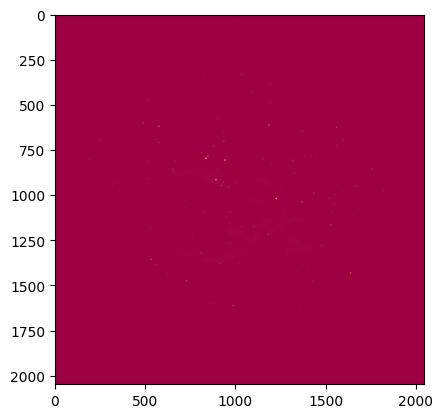

In [4]:
data=hdul[0].data
plt.imshow(data[0], cmap="Spectral")

In [5]:
path_cat = "catalogo.cat"
cat = Table.read(path_cat, format="ascii")

# Crear un archivo de anotación
clase = "fuente"
with open("galaxias_sextractor_marcos.txt", "w") as f:
    for row in cat:
        # Obtener las coordenadas de la galaxia
        x = row["X_IMAGE"]
        y = row["Y_IMAGE"]

        # Escribir la anotación en el archivo
        f.write(f"{x} {y} {clase}\n")

In [6]:
# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor_marcos.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1

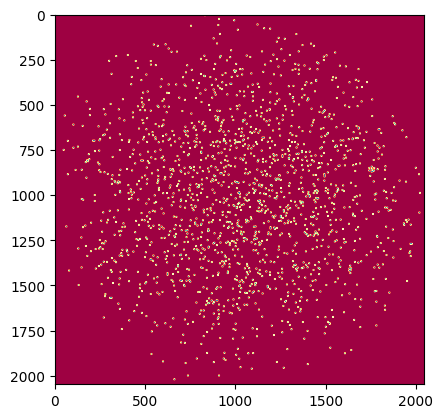

In [7]:
plt.imshow(label, cmap="Spectral")

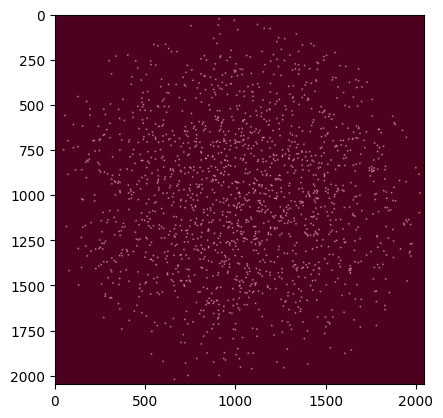

In [8]:
plt.imshow(label, cmap="gray")#label
plt.imshow(data[0], cmap="Spectral",alpha=0.5)#imagen
# Mostrar la imagen combinada
plt.show()

In [9]:
all_data = hdul[0].data

# Seleccionar x frecuencias distintas de manera aleatoria
num_samples = 400
indices = sorted(np.random.choice(all_data.shape[0], num_samples, replace=False))
data = all_data[indices]
print(indices)

[0, 2, 5, 10, 14, 15, 16, 22, 23, 24, 27, 34, 37, 38, 39, 40, 44, 45, 46, 47, 49, 52, 53, 56, 57, 58, 59, 60, 62, 64, 65, 68, 69, 75, 77, 82, 83, 84, 86, 87, 89, 90, 91, 92, 96, 97, 99, 103, 104, 105, 106, 108, 110, 119, 122, 123, 127, 130, 132, 135, 136, 137, 138, 140, 141, 143, 145, 146, 151, 152, 154, 156, 159, 160, 161, 163, 164, 165, 167, 168, 171, 173, 175, 176, 177, 179, 180, 181, 183, 189, 190, 192, 194, 195, 196, 203, 204, 208, 209, 218, 219, 220, 222, 224, 226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 243, 246, 248, 249, 250, 254, 260, 261, 262, 264, 265, 266, 268, 274, 275, 276, 277, 280, 281, 286, 292, 295, 297, 299, 300, 301, 303, 308, 310, 312, 316, 323, 326, 327, 328, 330, 332, 334, 336, 337, 345, 347, 348, 349, 351, 353, 354, 356, 359, 363, 365, 368, 372, 373, 375, 378, 380, 386, 387, 388, 391, 394, 395, 396, 400, 402, 404, 405, 406, 407, 413, 414, 415, 417, 418, 420, 423, 427, 431, 434, 435, 437, 438, 440, 441, 442, 444, 445, 447, 449, 451, 453, 456, 459, 461,

In [10]:
# Reformatear y normalizar las imágenes
input_data = np.array(data)
input_data = input_data.reshape((data.shape[0], data.shape[1], data.shape[2], 1)) #600, 2048, 2048, 1
input_data = input_data.astype("float32") / 255.0

# Crear un array de salida repetido x veces (uno para cada imagen de entrada)
output_data = np.repeat(label[np.newaxis, :, :], data.shape[0], axis=0)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

In [11]:
# Función para mostrar gráficos de precisión y pérdida
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Entrenamiento")
    plt.plot(history.history["val_accuracy"], label="Validación")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Entrenamiento")
    plt.plot(history.history["val_loss"], label="Validación")
    plt.xlabel("Epochs")	
    plt.ylabel("Pérdida")
    plt.legend()

    plt.show()

In [12]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(data.shape[1], data.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2023-04-10 23:05:33.219299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 23:05:33.225593: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

Epoch 1/5


2023-04-10 23:05:35.181397: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10737418240 exceeds 10% of free system memory.


160/160 [==============================] - 1043s 7s/step - loss: 0.1569 - accuracy: 0.9748 - val_loss: 0.0616 - val_accuracy: 0.9834
Epoch 2/5
160/160 [==============================] - 1041s 7s/step - loss: 0.0573 - accuracy: 0.9845 - val_loss: 0.0532 - val_accuracy: 0.9853
Epoch 3/5
160/160 [==============================] - 1046s 7s/step - loss: 0.0554 - accuracy: 0.9852 - val_loss: 0.0492 - val_accuracy: 0.9862
Epoch 4/5
160/160 [==============================] - 1049s 7s/step - loss: 0.0525 - accuracy: 0.9860 - val_loss: 0.0481 - val_accuracy: 0.9865
Epoch 5/5
160/160 [==============================] - 1058s 7s/step - loss: 0.0492 - accuracy: 0.9864 - val_loss: 0.0457 - val_accuracy: 0.9869


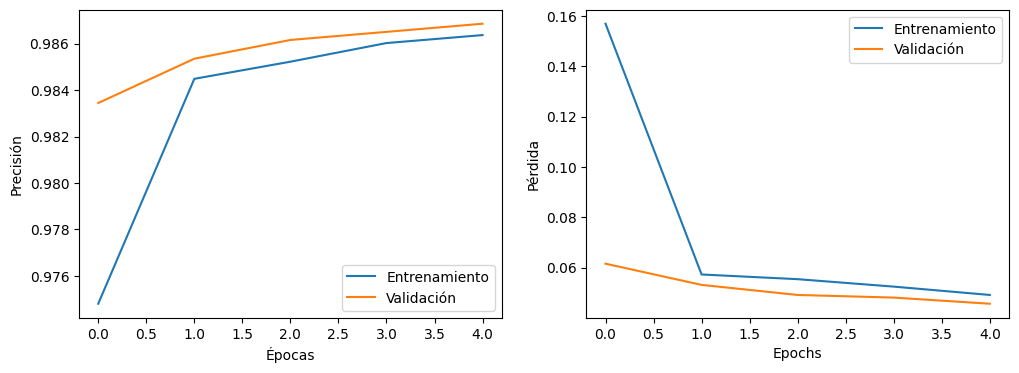

In [13]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=5, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn1.h5")
plot_history(history)

In [16]:
model.save("cnn1.h5")


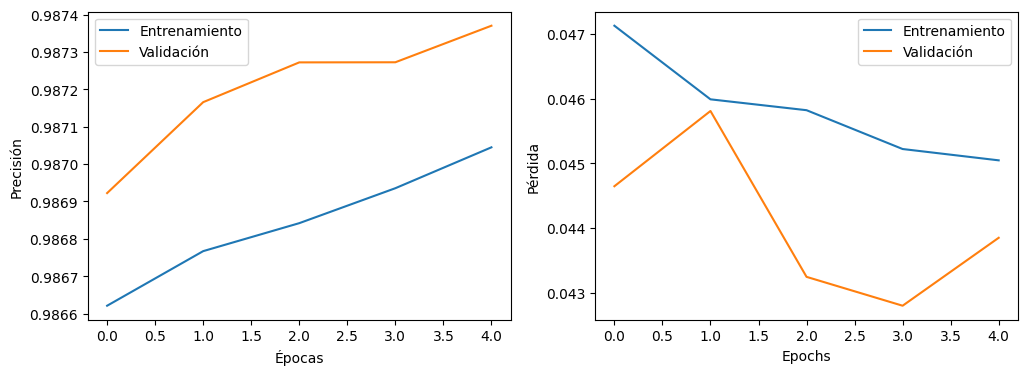

In [18]:
plot_history(history)

Epoch 1/5


2023-04-11 00:33:00.431576: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10737418240 exceeds 10% of free system memory.


80/80 [==============================] - 879s 11s/step - loss: 0.0471 - accuracy: 0.9866 - val_loss: 0.0446 - val_accuracy: 0.9869
Epoch 2/5
80/80 [==============================] - 881s 11s/step - loss: 0.0460 - accuracy: 0.9868 - val_loss: 0.0458 - val_accuracy: 0.9872
Epoch 3/5
80/80 [==============================] - 880s 11s/step - loss: 0.0458 - accuracy: 0.9868 - val_loss: 0.0432 - val_accuracy: 0.9873
Epoch 4/5
80/80 [==============================] - 880s 11s/step - loss: 0.0452 - accuracy: 0.9869 - val_loss: 0.0428 - val_accuracy: 0.9873
Epoch 5/5
80/80 [==============================] - 894s 11s/step - loss: 0.0450 - accuracy: 0.9870 - val_loss: 0.0438 - val_accuracy: 0.9874


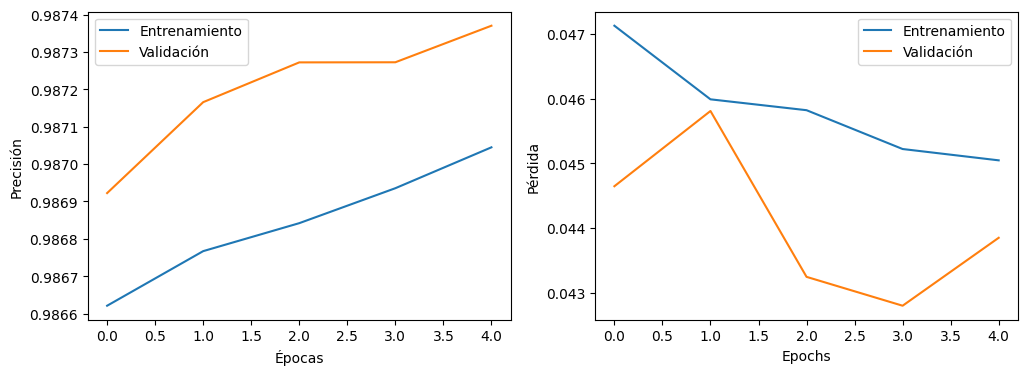

In [14]:
history = model.fit(x_train, y_train, epochs=5, batch_size=4, validation_data=(x_val, y_val))
plot_history(history)

In [15]:
stop

NameError: name 'stop' is not defined

In [ ]:


# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    "optimizer": ["adam", "rmsprop"],
    "activation": ["relu", "leaky_relu"],
    "learning_rate": [0.001, 0.01],
}

# Crear todas las combinaciones posibles de hiperparámetros
param_combinations = list(product(*param_grid.values()))

# Función para crear y compilar un modelo con una configuración específica de hiperparámetros
def create_model(optimizer, activation, learning_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(2048, 2048, 1)))
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

best_score = -1
best_params = None


# Prueba cada combinación de hiperparámetros
for params in param_combinations:
    optimizer, activation, learning_rate = params
    model = create_model(optimizer, activation, learning_rate)
    history = model.fit(
        x_train, y_train, epochs=10, batch_size=4, validation_data=(x_val, y_val), verbose=1
    )
    
    # Obtener la precisión de validación en la última época
    val_accuracy = history.history["val_accuracy"][-1]

    print(f"Validación de precisión: {val_accuracy:.4f} con {params}")
    
    # Mostrar gráficos de precisión y pérdida
    plot_history(history)

    # Si esta combinación de hiperparámetros es mejor que la anterior, guárdala
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params


In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    print("GPU disponible:", physical_devices)
else:
    print("No se encontró GPU disponible.")


In [ ]:
import os

os.environ["CUDA_HOME"] = "/usr/local/cuda-11.2"
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CUDA_HOME']}/lib64:{os.environ['LD_LIBRARY_PATH']}"

import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    print("GPU disponible:", physical_devices)
else:
    print("No se encontró GPU disponible.")